In [119]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from tqdm import tqdm
from matplotlib.lines import Line2D
import statannot

from cryptic_rnn import *
from performance_analysis import *

## RNN params

In [120]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005
xavier_gain = 0.0001

## running params
epochs = 1800
num_sims = 200

## Sequences

In [267]:
ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
input_vals.sort()
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print('cue_dict ',cue_dict)
primitives = generate_pos_primitives(all_syms, cue_dict)
print('primitives ',primitives)

trainseqs = generate_pos_other(ops, all_syms[:2], cue_dict)
trainseqs_b = generate_pos_other(ops, all_syms[:-1], cue_dict) + generate_balanced_primitives(ops, all_syms, cue_dict)
trainseqs_p = trainseqs + primitives
trainseqs_bp = trainseqs_b + primitives

testseqs2 = generate_pos_trials('+', all_syms, all_syms, cue_dict, steps = 2) 
testseqs3 = random.sample(generate_pos_trials('+', all_syms, all_syms, cue_dict, steps = 3), 64) 
testseqs4 = random.sample(generate_pos_trials('+', all_syms, all_syms, cue_dict, steps = 4), 64)


cue_dict  {'A': 2, 'B': 3, 'C': 6, 'D': 10}
primitives  [[('+', 'A'), '=', 2], [('+', 'B'), '=', 3], [('+', 'C'), '=', 6], [('+', 'D'), '=', 10]]


In [122]:
save_dir =  '../results/fraction_inputs/4_inputs'
with open(save_dir, 'rb') as f:
    res_t = pickle.load(f)


In [123]:
def generate_pairs(op, inputs, cue_dict, shift):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    for s in range(shift):
        inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [(op, inputs1[i]), (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

j=7

trial_list = []
for s in range(1, len(all_syms)+1):
    trial_list += (generate_pairs(ops, all_syms, cue_dict, s))

balanced_prims = generate_complex_primitives(ops, all_syms, cue_dict)
train_trials = [trial for trial in trial_list if trial not in balanced_prims]

basic_train = train_trials[:j]
trainseqs_b = basic_train + balanced_prims
trainseqs_p = basic_train + primitives
testseqs = generate_pos_trials(ops, all_syms, all_syms, cue_dict)
testseqs1 = [t for t in testseqs if t not in trainseqs_b]


# Performance scores

In [124]:
res1 = res_t[-1]
res2 = res_t[1]
res5 = res_t[4]
res8 = res_t[-1]


In [125]:
# extract results
tests = res1['tests']
mods_b = res1['mods_b']
mods_p = res1['mods_p']

In [134]:
def extract_step_curr_r2(res_step, all_testseqs):
    
    cue_dicts = res_step['cue_dicts']
    mods_b = res_step['mods_b']
    mods_p = res_step['mods_p']
    
    curricula = []
    add_steps = []
    r2_vals = []

    for i, test_seq in enumerate(all_testseqs):
        tsq = []
        for cd in cue_dicts:
            testseqs = change_dict(test_seq, cd)
            test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
            tsq.append(DataLoader(test_inputs, batch_size=batchsize, shuffle=True))
        
        r2reses_p = get_r2_and_preds(mods_p, tsq, hidden_size=20)['ind_r2s']
        r2reses_b = get_r2_and_preds(mods_b, tsq, hidden_size=20)['ind_r2s']
        
        r2_vals = r2_vals + r2reses_b + r2reses_p
        curricula = curricula + ['Balanced']*len(r2reses_b) + ['Primitive']*len(r2reses_p)
        add_steps += [i+1]*len(r2reses_b + r2reses_p)
        
    return {'add_steps': add_steps, 'curricula':curricula , 'r2s': r2_vals}


legend_elements_bp = [Line2D([0], [0], marker="o", color='w', markerfacecolor =bp_colors[0], markersize=msize, label='Balanced'),
                   Line2D([0], [0], marker="o", color='w', markerfacecolor =bp_colors[1], markersize=msize, label='Primitive')] 


In [135]:
r2res_2 = extract_step_curr_r2(res2, all_testseqs)
r2res_8 = extract_step_curr_r2(res8, all_testseqs)
r2res_5 = extract_step_curr_r2(res5, all_testseqs)


In [136]:
all_steps = r2res_2['add_steps'] + r2res_5['add_steps'] + r2res_8['add_steps']
all_currs = r2res_2['curricula'] + r2res_5['curricula'] + r2res_8['curricula']
all_r2vals = r2res_2['r2s'] + r2res_5['r2s'] + r2res_8['r2s']
base_trials = [2]*len(r2res_2['add_steps']) + [5]*len(r2res_5['add_steps']) + [8]*len(r2res_8['add_steps'])

In [137]:
stepwise_df = pd.DataFrame({'Base Trials': base_trials, 'Curricula': all_currs, '$R^2$': all_r2vals, 'Addition steps': all_steps})

In [138]:
df2 = stepwise_df[stepwise_df['Base Trials'] == 2]
df8 = stepwise_df[stepwise_df['Base Trials'] == 8]
df5 = stepwise_df[stepwise_df['Base Trials'] == 5]

In [140]:
bp_pal = {'Balanced': '#00A7E1', 'Primitive':'#F17720'}



p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
2_Balanced v.s. 2_Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.309e-30 stat=5.270e+02
Using zero_method  wilcox
1_Balanced v.s. 1_Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.748e-31 stat=3.870e+02
Using zero_method  wilcox
3_Balanced v.s. 3_Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=5.982e-26 stat=1.310e+03
Using zero_method  wilcox
4_Balanced v.s. 4_Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=4.784e-26 stat=1.293e+03


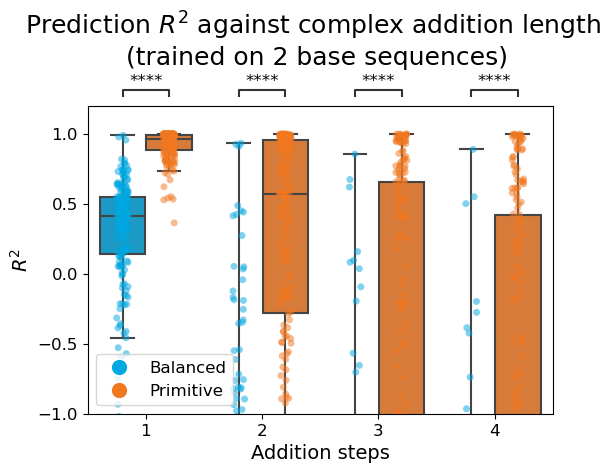

In [287]:
## 5 training trials
fig, ax = plt.subplots(figsize = (6,4))
sns.boxplot(data = df2, x='Addition steps', y='$R^2$', hue='Curricula', palette = bp_pal, showfliers = False)
sns.stripplot(data = df2, x='Addition steps', y='$R^2$', hue='Curricula', palette = bp_pal, dodge=True)
plt.setp(ax.collections, alpha=.5)
ax.set_ylim(-1,1.2)
ax.set_yticks(np.arange(-1,1.1,0.5))
plt.suptitle('Prediction $R^2$ against complex addition length\n (trained on 2 base sequences)', y=1.12)

statannot.add_stat_annotation(
    ax,
    data=df2,
    x='Addition steps',
    y='$R^2$',
    hue = 'Curricula',
    box_pairs=[((1,'Balanced'), (1, 'Primitive')),\
              ((2,'Balanced'), (2, 'Primitive')),
              ((3,'Balanced'), (3, 'Primitive')),
              ((4,'Balanced'), (4, 'Primitive'))],
    test="Wilcoxon",
    text_format="star",
    loc="outside",
)
plt.legend(handles = legend_elements_bp)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
2_Balanced v.s. 2_Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=4.982e-25 stat=1.473e+03
Using zero_method  wilcox
1_Balanced v.s. 1_Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.195e-01 stat=8.270e+03
Using zero_method  wilcox
3_Balanced v.s. 3_Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=2.395e-16 stat=3.194e+03
Using zero_method  wilcox
4_Balanced v.s. 4_Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=3.286e-12 stat=4.184e+03


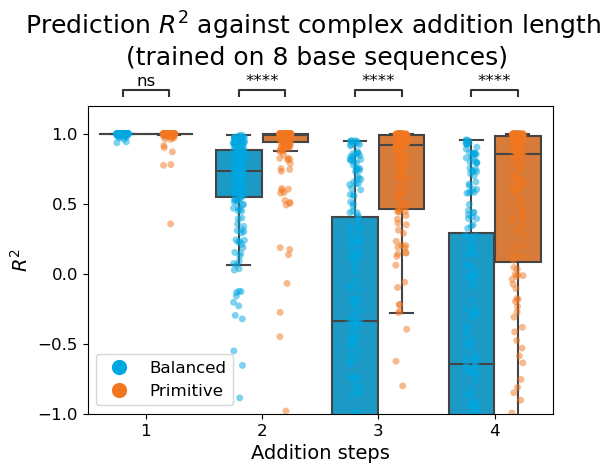

In [288]:
## 8 training trials
fig, ax = plt.subplots(figsize = (6,4))
sns.boxplot(data = df8, x='Addition steps', y='$R^2$', hue='Curricula', palette = bp_pal, showfliers = False)
sns.stripplot(data = df8, x='Addition steps', y='$R^2$', hue='Curricula', palette = bp_pal, dodge=True)
plt.setp(ax.collections, alpha=.5)
ax.set_ylim(-1,1.2)
ax.set_yticks(np.arange(-1,1.1,0.5))
plt.suptitle('Prediction $R^2$ against complex addition length\n (trained on 8 base sequences)', y=1.12)

statannot.add_stat_annotation(
    ax,
    data=df8,
    x='Addition steps',
    y='$R^2$',
    hue = 'Curricula',
    box_pairs=[((1,'Balanced'), (1, 'Primitive')),\
              ((2,'Balanced'), (2, 'Primitive')),
              ((3,'Balanced'), (3, 'Primitive')),
              ((4,'Balanced'), (4, 'Primitive'))],
    test="Wilcoxon",
    text_format="star",
    loc="outside",
)
plt.legend(handles = legend_elements_bp)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
2_Balanced v.s. 2_Primitives: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.309e-30 stat=5.270e+02
Using zero_method  wilcox
1_Balanced v.s. 1_Primitives: Wilcoxon test (paired samples) with Bonferroni correction, P_val=6.224e-32 stat=3.160e+02
Using zero_method  wilcox
3_Balanced v.s. 3_Primitives: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.144e-29 stat=6.800e+02
Using zero_method  wilcox
4_Balanced v.s. 4_Primitives: Wilcoxon test (paired samples) with Bonferroni correction, P_val=3.677e-26 stat=1.273e+03


(<AxesSubplot: xlabel='Addition steps', ylabel='$R^2$'>,
  <statannot.StatResult.StatResult at 0x7f85b22ad130>])

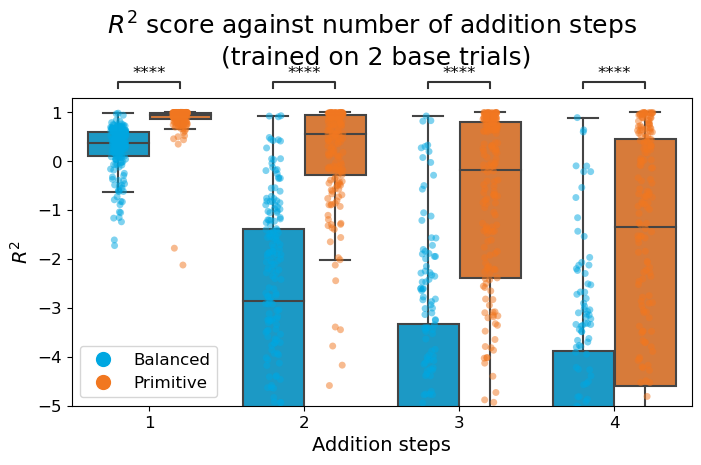

In [336]:
## 8 training trials
fig, ax = plt.subplots(figsize = (8,4))
sns.boxplot(data = df2, x='Addition steps', y='$R^2$', hue='Curricula', palette = bp_pal, showfliers = False)
sns.stripplot(data = df2, x='Addition steps', y='$R^2$', hue='Curricula', palette = bp_pal, dodge=True)
plt.setp(ax.collections, alpha=.5)
ax.set_ylim(-5,1.3)
plt.suptitle('$R^2$ score against number of addition steps\n (trained on 2 base trials)', y=1.1)


plt.legend(handles = legend_elements_bp)
statannot.add_stat_annotation(
    ax,
    data=df2,
    x='Addition steps',
    y='$R^2$',
    hue = 'Curricula',
    box_pairs=[((1,'Balanced'), (1, 'Primitives')),\
              ((2,'Balanced'), (2, 'Primitives')),
              ((3,'Balanced'), (3, 'Primitives')),
              ((4,'Balanced'), (4, 'Primitives'))],
    test="Wilcoxon",
    text_format="star",
    loc="outside",
)

In [37]:
r2res_p1 = get_r2_and_preds(mods_p, tests, hidden_size=20)
r2res_b1 = get_r2_and_preds(mods_b, tests, hidden_size=20)

r2res_p2 = get_r2_and_preds(mods_p, test_data_2, hidden_size=20)
r2res_b2 = get_r2_and_preds(mods_b, test_data_2, hidden_size=20)

r2res_p3 = get_r2_and_preds(mods_p, test_data_3, hidden_size=20)
r2res_b3 = get_r2_and_preds(mods_b, test_data_3, hidden_size=20)

r2res_p4 = get_r2_and_preds(mods_p, test_data_4, hidden_size=20)
r2res_b4 = get_r2_and_preds(mods_b, test_data_4, hidden_size=20)

Text(0.5, 1.02, 'RNN predictions against ground truth \n complex addition')

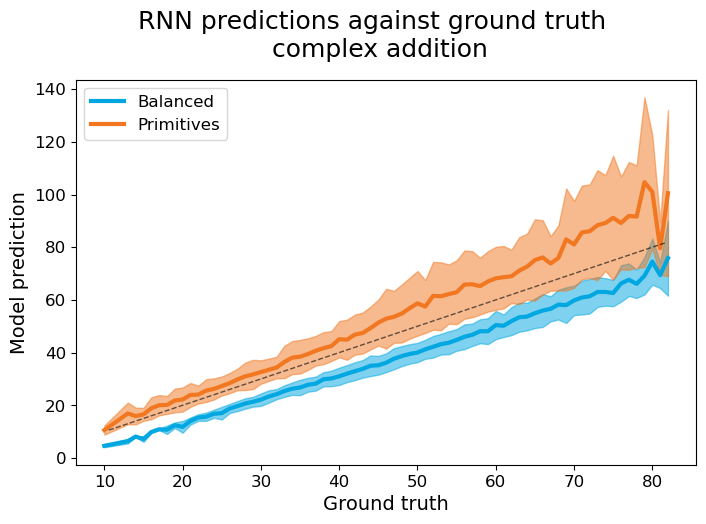

In [38]:
# aggregate all predictions vs labels across models
all_dfs_b = pd.concat(r2res_b4['ind_dfs'])
all_dfs_p = pd.concat(r2res_p4['ind_dfs'])

labels = ['Balanced', 'Primitives']
plt.rcParams['figure.figsize'] = (8,5)

for i, all_dfs in enumerate([all_dfs_b, all_dfs_p]):
    
    agg_df = all_dfs.groupby(['label']).agg({'pred': ['mean', 'std']})
    yvals = agg_df['pred']['mean']
    yerr = agg_df['pred']['std']
    xvals = agg_df.index
    plt.plot(xvals,yvals, color = bp_colors[i], linewidth=3,label=labels[i])
    plt.fill_between(xvals, yvals - yerr, yvals+yerr, color = bp_colors[i], alpha=0.5)
    xy = np.arange(np.min(yvals),np.max(xvals))
    
plt.plot(xy, xy, color='black', linestyle='dashed',linewidth=1, alpha=0.6)
plt.xlabel('Ground truth')
plt.ylabel('Model prediction')
plt.legend(loc = 'upper left')
plt.suptitle('RNN predictions against ground truth \n complex addition', y=1.02)

# MSE Analysis

In [152]:
def testset_MSELoss(res1, testsets, hidden_size=20):
    mods_b = res1['mods_b']
    mods_p = res1['mods_p']
    criterion = nn.MSELoss()
    mse_b = []
    mse_p = []
    for i in range(len(mods_b)):
        mse_b.append(test_modloss(mods_b[i], [testsets[i]], criterion, hidden_size)[0]) 
        mse_p.append(test_modloss(mods_p[i], [testsets[i]], criterion, hidden_size)[0]) 
    return {'mse_b': mse_b, 'mse_p': mse_p}


In [111]:
lossres1 = extract_MSELoss(res1)

In [47]:
lossres = testset_MSELoss(res1, test_data_2)

In [60]:
lossesb = np.sqrt(lossres['mse_b'])
lossesp = np.sqrt(lossres['mse_p'])
curricula = ['Balanced']*len(lossesb) + ['Primitives']*len(lossesp)
rmse = np.append(lossesb, lossesp)

rmse_df = pd.DataFrame({'Curriculum':curricula, 'RMSE':rmse})

N = len(lossesb)
x_jitter = np.repeat([0], N) + np.random.normal(0, 0.03, N)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
Balanced v.s. Primitives: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.623e-112 stat=0.000e+00


(<AxesSubplot: title={'center': 'Complex addition'}, xlabel='Curriculum', ylabel='RMSE'>,
 [<statannot.StatResult.StatResult at 0x7f98b17a1a00>])

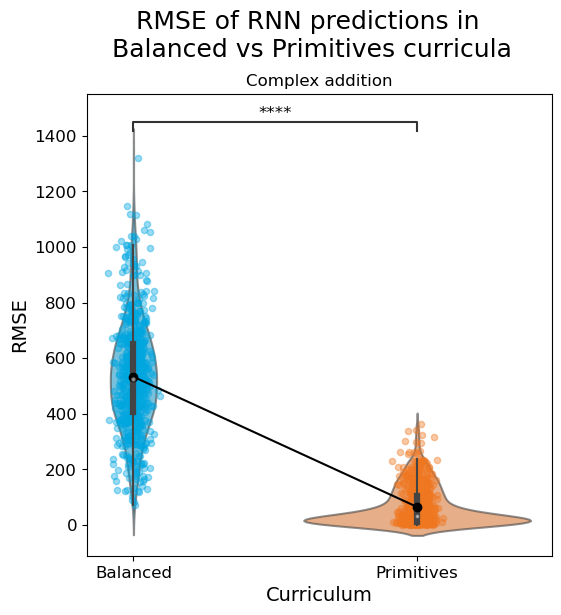

In [73]:
fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (6,6)
sns.violinplot(data=rmse_df, x='Curriculum', y='RMSE', capsize=0.1, palette=bp_pal, errwidth=1)
plt.setp(ax.collections, alpha=.6)
y_p = [np.mean(lossesb), np.mean(lossesp)]
ax.plot([0,1], y_p, color = 'black', marker = 'o')
plt.scatter(x_jitter, lossesb, alpha = 0.4, color = bp_colors[0], s= 20)
plt.scatter(x_jitter+1, lossesp, alpha = 0.4, color = bp_colors[1], s=20)
plt.suptitle('RMSE of RNN predictions in \nBalanced vs Primitives curricula', y=1.02)
ax.title.set_text('Complex addition')
statannot.add_stat_annotation(
    ax,
    data=rmse_df,
    x='Curriculum',
    y='RMSE',
    box_pairs=[('Balanced', 'Primitives')],
    test="Wilcoxon",
    text_format="star",
    loc="inside",
)

In [85]:
lossesb = np.sqrt(lossres3['mse_b'])
lossesp = np.sqrt(lossres3['mse_p'])
curricula = ['Balanced']*len(lossesb) + ['Primitives']*len(lossesp)
rmse = np.append(lossesb, lossesp)

rmse_df = pd.DataFrame({'Curriculum':curricula, 'RMSE':rmse})
N = len(lossesb)
x_jitter = np.repeat([0], N) + np.random.normal(0, 0.03, N)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
Balanced v.s. Primitives: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.623e-112 stat=0.000e+00


(<AxesSubplot: title={'center': 'Complex addition'}, xlabel='Curriculum', ylabel='RMSE'>,
 [<statannot.StatResult.StatResult at 0x7f9890f5fcd0>])

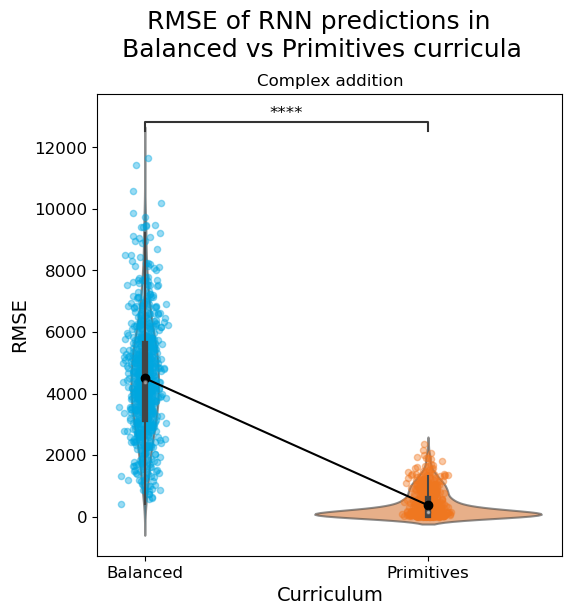

In [92]:
fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (6,6)
sns.violinplot(data=rmse_df, x='Curriculum', y='RMSE', capsize=0.1, palette=bp_pal, errwidth=1)
plt.setp(ax.collections, alpha=.6)
y_p = [np.mean(lossesb), np.mean(lossesp)]
ax.plot([0,1], y_p, color = 'black', marker = 'o')
plt.scatter(x_jitter, lossesb, alpha = 0.4, color = bp_colors[0], s= 20)
plt.scatter(x_jitter+1, lossesp, alpha = 0.4, color = bp_colors[1], s=20)
plt.suptitle('RMSE of RNN predictions in \nBalanced vs Primitives curricula', y=1.02)
ax.title.set_text('Complex addition')
#ax.set_ylim(0, 1400)
statannot.add_stat_annotation(
    ax,
    data=rmse_df,
    x='Curriculum',
    y='RMSE',
    box_pairs=[('Balanced', 'Primitives')],
    test="Wilcoxon",
    text_format="star",
    loc="inside",
)


In [178]:
lossres1 = testset_MSELoss(res2, tests)
lossres2 = testset_MSELoss(res2, test_data_2)
lossres3 = testset_MSELoss(res2, test_data_3)
lossres4 = testset_MSELoss(res2, test_data_4)

In [179]:
outs1 = np.mean([t[-1] for t in testseqs1])
outs2 = np.mean([t[-1] for t in testseqs2])
outs3 = np.mean([t[-1] for t in testseqs3])
outs4 = np.mean([t[-1] for t in testseqs4])

In [180]:
lossesb1 = np.sqrt(lossres1['mse_b'])/outs1
lossesp1 = np.sqrt(lossres1['mse_p'])/outs1

lossesb2 = np.sqrt(lossres['mse_b'])/outs2
lossesp2 = np.sqrt(lossres['mse_p'])/outs2

lossesb3 = np.sqrt(lossres3['mse_b'])/outs3
lossesp3 = np.sqrt(lossres3['mse_p'])/outs3

lossesb4 = np.sqrt(lossres4['mse_b'])/outs4
lossesp4 = np.sqrt(lossres4['mse_p'])/outs4


N = len(lossesb2)
all_loss = np.concatenate([lossesb1, lossesp1, lossesb2, lossesp2, lossesb3, lossesp3 ,lossesb4, lossesp4])
all_currs = (['Balanced']*N + ['Primitives']*N)*4
num_steps = [1]*N*2 + [2]*N*2 + [3]*N*2 + [4]*N*2

step_df = pd.DataFrame({'Step': num_steps, 'Curriculum': all_currs, 'RMSE': all_loss})

<AxesSubplot: xlabel='Step', ylabel='RMSE'>

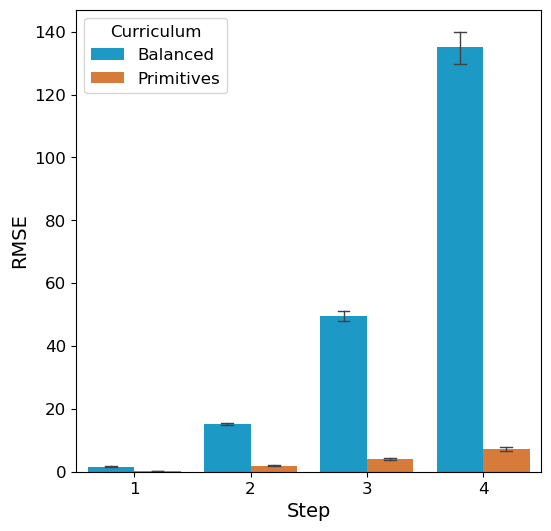

In [181]:
sns.barplot(data=step_df, x= 'Step',y='RMSE', hue='Curriculum', capsize=0.1, palette=bp_pal, errwidth=1)


# RSA

In [226]:
ca, cb, cc, cd = 'green', 'blue', 'orange', 'red'
colors1 = ([ca]*16 + [cb]*16 + [cc]*16 + [ cd]*16)*2
colors2 = ([ca]*4 + [cb]*4 + [cc]*4 + [ cd]*4)*8
colors3 = [ca, cb, cc, cd]*32

msize = 12
legend_elements = [Line2D([0], [0], marker=6, color='w', markerfacecolor =ca, markersize=msize, label=' + A _ _'),
                   Line2D([0], [0], marker=6, color='w', markerfacecolor =cb, markersize=msize, label=' + B _ _'), 
                   Line2D([0], [0], marker=6, color='w', markerfacecolor =cc, markersize=msize, label=' + C _ _'),
                   Line2D([0], [0], marker=6, color='w', markerfacecolor =cd, markersize=msize, label=' + D _ _'),
                   Line2D([0], [0], marker=7, color='w', markerfacecolor=ca, markersize=msize, label=' _ + A _'),
                   Line2D([0], [0], marker=7, color='w', markerfacecolor=cb, markersize=msize, label=' _ + B _'), 
                   Line2D([0], [0], marker=7, color='w', markerfacecolor=cc, markersize=msize, label=' _ + C _'),
                   Line2D([0], [0], marker=7, color='w', markerfacecolor=cd, markersize=msize, label=' _ + D _'),
                   Line2D([0], [0], marker=4, color='w', markerfacecolor=ca, markersize=msize, label=' _ _ + A'),
                   Line2D([0], [0], marker=4, color='w', markerfacecolor=cb, markersize=msize, label=' _ _ + B'), 
                   Line2D([0], [0], marker=4, color='w', markerfacecolor=cc, markersize=msize, label=' _ _ + C'),
                   Line2D([0], [0], marker=4, color='w', markerfacecolor=cd, markersize=msize, label=' _ _ + D')
                   ]


def MDS_plot_single(ax, meanRDM, testseqs, MDStype = 'MDS', title = '', plotlines=True, rand_state=0, min_dim=0):

    if MDStype == 'PCA':
        mds = PCA(n_components=3)
    if MDStype == 'MDS':
        mds = MDS(dissimilarity='precomputed',random_state=rand_state, n_components=3)

    X_transform = mds.fit_transform(meanRDM)
    for i in range(len(testseqs)):
        ax.scatter(X_transform[i,min_dim], X_transform[i,min_dim+1], marker=7, color = colors1[i], s=180)
        ax.scatter(X_transform[i,min_dim], X_transform[i,min_dim+1], marker=6, color = colors2[i], s=180)
        ax.scatter(X_transform[i,min_dim], X_transform[i,min_dim+1], marker=4, color = colors3[i], s=180)
        
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    plt.suptitle('2D-'+MDStype+': '+title)
   

In [16]:
Tmax = 2*len(testseqs2[0][:-1])-1-1
allrdms2 = calculate_RDMs(res2, testseqs2, num_classes=22, batchsize=1,hidden_size=20, Tmax=Tmax)

allrdms5 = calculate_RDMs(res5, testseqs2, num_classes=22, batchsize=1,hidden_size=20, Tmax=Tmax)

allrdms8 = calculate_RDMs(res8, testseqs2, num_classes=22, batchsize=1,hidden_size=20, Tmax=Tmax)

In [228]:
np.array(allrdms2['rdms_p']).shape

(6, 200, 64, 64)

In [ ]:
### for 2 inputs

In [230]:
dps = []
for j in [0,2,4]:
    dps.append(np.array(allrdms2['rdms_p'][j]).mean(axis=0))

Text(0.5, 0.96, '2D-MDS: Primitive \n(trained on 2 base sequences)')

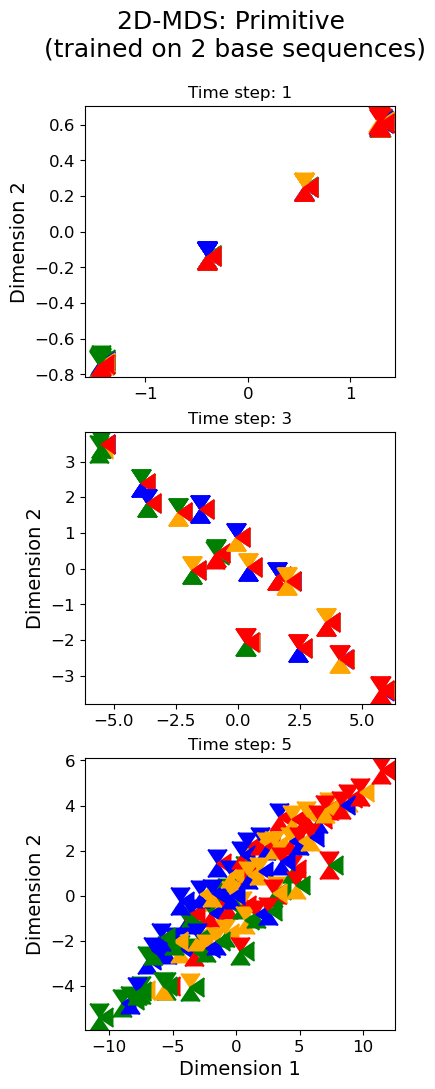

In [255]:
plt.rcParams['figure.figsize'] = (4,12)
fig, ax = plt.subplots(3,1)
ax = ax.flatten()

for i in range(3):
    MDS_plot_single(ax[i], dps[i], testseqs2, rand_state=9)
    ax[i].title.set_text('Time step: '+str(2*i+1))
    ax[i].set_xlabel('')
ax[-1].set_xlabel('Dimension 1')
plt.suptitle('2D-MDS: Primitive \n(trained on 2 base sequences)', y=0.96)
#fig.legend(handles = legend_elements, loc='center right', bbox_to_anchor=(1.25, 0.5))
#fig.legend(handles = legend_elements, loc='center right', bbox_to_anchor=(1.25, 0.5))

#loc='center left' bbox_to_anchor=(1, 0.5)

In [247]:
dbs = []
for j in [0,2,4]:
    dbs.append(np.array(allrdms2['rdms_b'][j]).mean(axis=0))


Text(0.5, 0.96, '2D-MDS: Balanced \n(trained on 2 base sequences)')

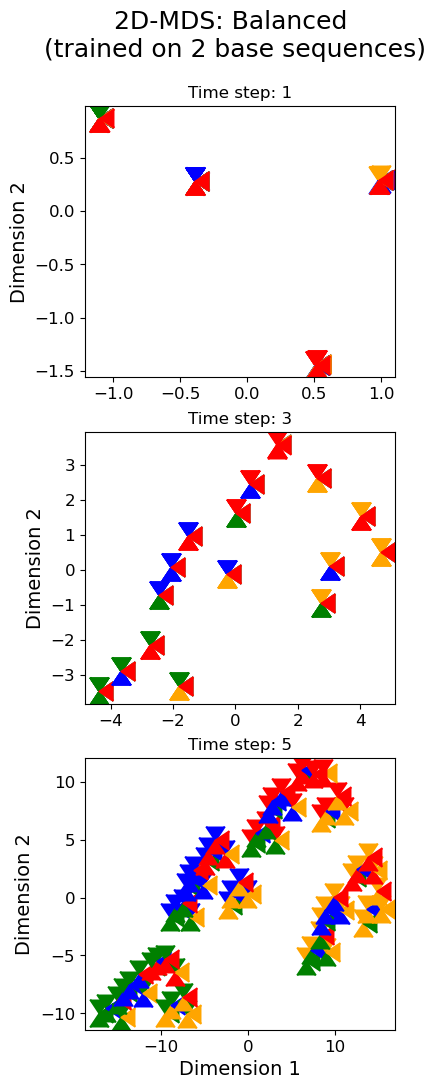

In [256]:
plt.rcParams['figure.figsize'] = (4,12)
fig, ax = plt.subplots(3,1)
ax = ax.flatten()

for i in range(3):
    MDS_plot_single(ax[i], dbs[i], testseqs2, rand_state=9)
    ax[i].title.set_text('Time step: '+str(2*i+1))
    ax[i].set_xlabel('')
ax[-1].set_xlabel('Dimension 1')
plt.suptitle('2D-MDS: Balanced \n(trained on 2 base sequences)', y=0.96)
#fig.legend(handles = legend_elements, loc='center right', bbox_to_anchor=(1.25, 0.5))

#loc='center left' bbox_to_anchor=(1, 0.5)

In [ ]:
# for 8 inputs

In [347]:
mat = dbs[2]

pca = PCA(n_components=3)
pca_fit = pca.fit_transform(mat)
pca.explained_variance_ratio_


array([0.69294415, 0.27754177, 0.00988717])

# Control models

In [57]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statannot
from sklearn.linear_model import LinearRegression

bp_colors_dark = ['#003D70', '#AE4F0A']

In [156]:

def tuple_output(tuple_step, cue_dict):
    out = cue_dict[tuple_step[1]]
    if tuple_step[0]=='-':
        out = -1*out
    return out

def control_importance(rdm, all_seqs, cuedict, control_mod):

    newseqs = change_dict(all_seqs, cuedict)
    outs_truth = [t[-1] for t in newseqs]
    truth_RDM = abs(np.array([outs_truth]*64) - np.array([outs_truth]*64).T)
       
    outs_aug = [tuple_output(t[0], cuedict) for t in newseqs]
    aug_RDM = abs(np.array([outs_aug]*64) - np.array([outs_aug]*64).T)

    outs_simple = [tuple_output(t[0], cuedict) + tuple_output(t[1], cuedict) for t in newseqs]
    simple_RDM = abs(np.array([outs_simple]*64) - np.array([outs_simple]*64).T)

    y = rdm.reshape(-1)
    x_truth = truth_RDM.reshape(-1,1) 
    x_aug = aug_RDM.reshape(-1,1) 
    x_simple = simple_RDM.reshape(-1,1) 
    
    r_sqs = []
    for xvals in [x_aug, x_simple, x_truth]:
        model = LinearRegression().fit(xvals, y)
        r_sqs.append(model.score(xvals, y))
    

    x = pd.DataFrame({'ground_truth': x_truth.reshape(-1),
                      'aug_control': x_aug.reshape(-1),
                      'simple_control': x_simple.reshape(-1)})

    lm = ols('y ~ simple_control + ground_truth +  aug_control',x).fit()
    r_sqs.append(lm.rsquared)
    var_exp = np.array(r_sqs)
         
    return var_exp

def get_step_coeffs(RDMs, step_num,  all_seqs, cue_dicts, control_mod=None):
    N = len(RDMs[0])
    if (control_mod == 'aug') or (control_mod == 'ground_truth') or (control_mod == 'simple_control'):
        control_mod_names = [control_mod]*N
        importance_vals = np.empty((0,1))
    else:
        control_mod_names = ['augend']*N + ['simple']*N + ['ground truth']*N + ['multiple']*N
        importance_vals = np.empty((0,4))
    for i, rdm_mat in enumerate(RDMs[step_num]):
        imps = control_importance(rdm_mat, all_seqs, cue_dicts[i], control_mod)
        importance_vals = np.vstack([importance_vals, imps])
   
    coeff_vals = importance_vals.T.reshape(-1)
    
    return coeff_vals, control_mod_names

def all_steps_coeffs(RDM_set, control_mod=None):
    all_coeffs = np.empty((0,1))
    all_controls = []
    step_num = []
    for st in range(4):
        print('step ', st)
        step_coeffs, step_mods = get_step_coeffs(RDM_set,step_num=st,  control_mod=control_mod)
        all_coeffs = np.append(all_coeffs, step_coeffs)
        all_controls += step_mods
        step_num += [st+2]*len(step_mods)
    return pd.DataFrame({'step': step_num, 'variance explained': all_coeffs, 'control':all_controls})

In [159]:
cuedicts = res2['cue_dicts']
coefs1b, names1b = get_step_coeffs(allrdms2['rdms_b'],1, testseqs2, cuedicts)
coefs1p, names1p = get_step_coeffs(allrdms2['rdms_p'],1, testseqs2, cuedicts)

coefs = np.append(coefs1b, coefs1p)
curricula = ['Balanced']*len(coefs1b) + ['Primitive']*len(coefs1p)
controls = names1b + names1p
r2_df = pd.DataFrame({'R2': coefs, 'Control': controls, 'Curricula': curricula})

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
simple_Balanced v.s. simple_Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=5.745e-34 stat=0.000e+00
Using zero_method  wilcox
augend_Balanced v.s. augend_Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=5.745e-34 stat=0.000e+00
Using zero_method  wilcox
ground truth_Balanced v.s. ground truth_Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=5.745e-34 stat=0.000e+00
Using zero_method  wilcox
multiple_Balanced v.s. multiple_Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=5.745e-34 stat=0.000e+00


Text(33.222222222222214, 0.5, '$R^2$')

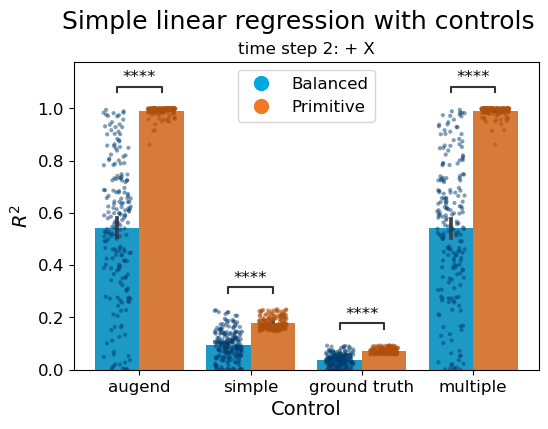

In [182]:
fig, ax = plt.subplots(figsize = (6,4))
sns.barplot(data = r2_df, x='Control', y='R2', hue='Curricula', palette = bp_pal)
sns.stripplot(data = r2_df, x='Control', y='R2', hue='Curricula', dodge = True, palette = bp_colors_dark, jitter=0.25, s=3)
plt.setp(ax.collections, alpha=.5)

statannot.add_stat_annotation(
    ax,
    data=r2_df,
    x= 'Control',
    y='R2',
    hue = 'Curricula',
    box_pairs=[(('ground truth','Balanced'), ('ground truth','Primitive')),
               (('simple','Balanced'), ('simple','Primitive')),
              (('augend','Balanced'), ('augend','Primitive')),
              (('multiple','Balanced'), ('multiple','Primitive'))],
    test="Wilcoxon",
    text_format="star",
    loc="inside",
)
plt.legend(handles = legend_elements_bp)
plt.suptitle('Simple linear regression with controls', y=1.01)
ax.title.set_text('time step 2: + X')
ax.set_ylabel('$R^2$')

In [172]:
cuedicts = res2['cue_dicts']
coefs3b, names3b = get_step_coeffs(allrdms2['rdms_b'],3, testseqs2, cuedicts)
coefs3p, names3p = get_step_coeffs(allrdms2['rdms_p'],3, testseqs2, cuedicts)

coefs = np.append(coefs3b, coefs3p)
curricula = ['Balanced']*len(coefs3b) + ['Primitive']*len(coefs3p)
controls = names3b + names3p
r2_df3 = pd.DataFrame({'R2': coefs, 'Control': controls, 'Curricula': curricula})

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
simple_Balanced v.s. simple_Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=5.832e-34 stat=1.000e+00
Using zero_method  wilcox
augend_Balanced v.s. augend_Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=6.748e-04 stat=6.967e+03
Using zero_method  wilcox
ground truth_Balanced v.s. ground truth_Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=5.832e-34 stat=1.000e+00
Using zero_method  wilcox
multiple_Balanced v.s. multiple_Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=5.920e-34 stat=2.000e+00


Text(33.222222222222214, 0.5, '$R^2$')

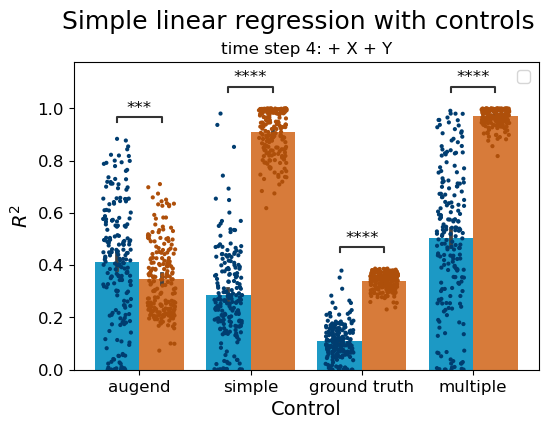

In [176]:
fig, ax = plt.subplots(figsize = (6,4))
sns.barplot(data = r2_df3, x='Control', y='R2', hue='Curricula', palette = bp_pal)
sns.stripplot(data = r2_df3, x='Control', y='R2', hue='Curricula', dodge = True, palette = bp_colors_dark, jitter=0.25, s=3)
statannot.add_stat_annotation(
    ax,
    data=r2_df3,
    x= 'Control',
    y='R2',
    hue = 'Curricula',
    box_pairs=[(('ground truth','Balanced'), ('ground truth','Primitive')),
                   (('simple','Balanced'), ('simple','Primitive')),
                  (('augend','Balanced'), ('augend','Primitive')),
                  (('multiple','Balanced'), ('multiple','Primitive'))],
    test="Wilcoxon",
    text_format="star",
    loc="inside",
)
plt.legend(handles =[])

plt.suptitle('Simple linear regression with controls', y=1.01)
ax.title.set_text('time step 4: + X + Y')
ax.set_ylabel('$R^2$')

In [179]:
coefs5b, names5b = get_step_coeffs(allrdms2['rdms_b'],5, testseqs2, cuedicts)
coefs5p, names5p = get_step_coeffs(allrdms2['rdms_p'],5, testseqs2, cuedicts)

coefs = np.append(coefs5b, coefs5p)
curricula = ['Balanced']*len(coefs5b) + ['Primitive']*len(coefs5p)
controls = names5b + names5p
r2_df5 = pd.DataFrame({'R2': coefs, 'Control': controls, 'Curricula': curricula})

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
simple_Balanced v.s. simple_Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.546e-32 stat=2.210e+02
Using zero_method  wilcox
augend_Balanced v.s. augend_Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=6.011e-13 stat=3.996e+03
Using zero_method  wilcox
ground truth_Balanced v.s. ground truth_Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=5.832e-34 stat=1.000e+00
Using zero_method  wilcox
multiple_Balanced v.s. multiple_Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.002e-33 stat=3.700e+01


Text(33.222222222222214, 0.5, '$R^2$')

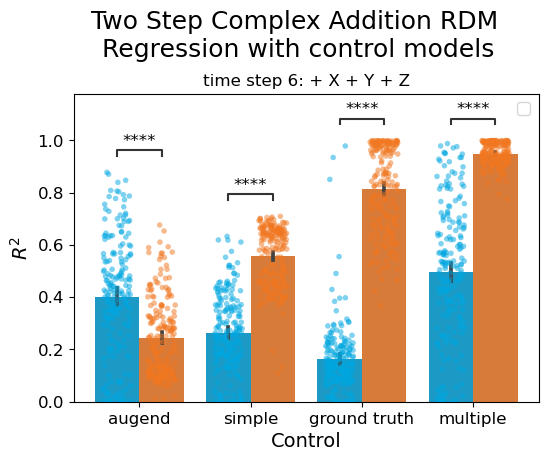

In [203]:
fig, ax = plt.subplots(figsize = (6,4))
sns.barplot(data = r2_df5, x='Control', y='R2', hue='Curricula', palette = bp_pal)
sns.stripplot(data = r2_df5, x='Control', y='R2', hue='Curricula', dodge = True, palette = bp_pal, jitter=0.25, s=4)
plt.setp(ax.collections, alpha=.5)

statannot.add_stat_annotation(
    ax,
    data=r2_df5,
    x= 'Control',
    y='R2',
    hue = 'Curricula',
    box_pairs=[(('ground truth','Balanced'), ('ground truth','Primitive')),
                   (('simple','Balanced'), ('simple','Primitive')),
                  (('augend','Balanced'), ('augend','Primitive')),
                  (('multiple','Balanced'), ('multiple','Primitive'))],
    test="Wilcoxon",
    text_format="star",
    loc="inside",
)
plt.legend(handles = [])
#plt.suptitle('Two Step Complex Addition RDM \nRegression with control models', y=1.09)
ax.title.set_text('time step 6: + X + Y + Z')
ax.set_ylabel('$R^2$')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
simple_Balanced v.s. simple_Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.546e-32 stat=2.210e+02
Using zero_method  wilcox
augend_Balanced v.s. augend_Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=6.011e-13 stat=3.996e+03
Using zero_method  wilcox
ground truth_Balanced v.s. ground truth_Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=5.832e-34 stat=1.000e+00
Using zero_method  wilcox
multiple_Balanced v.s. multiple_Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.002e-33 stat=3.700e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
simple_Bal

Text(0.5, 0.97, 'Two Step Complex Addition RDM \nRegression with control models')

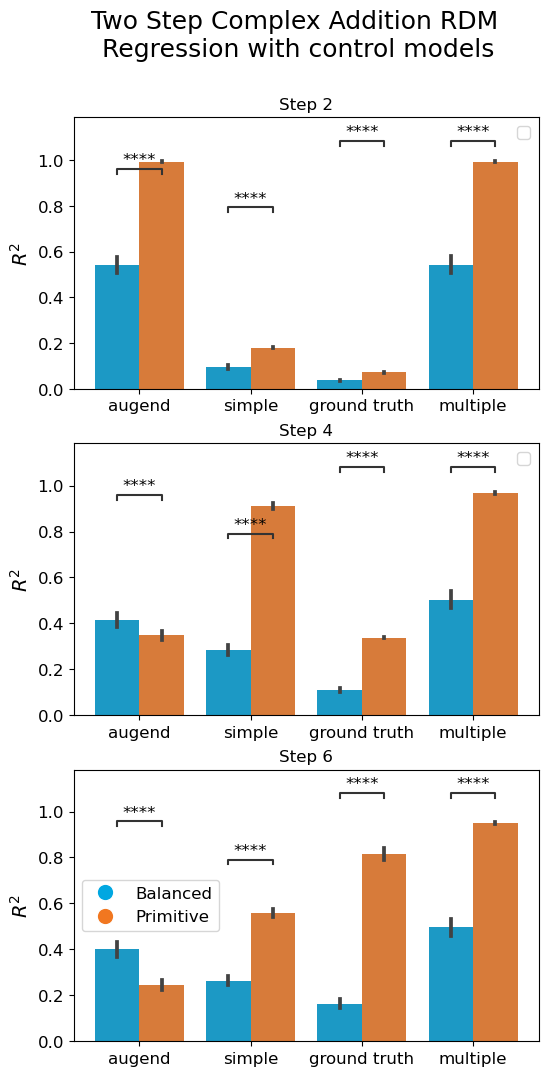

In [259]:
fig, axs = plt.subplots(3,1, figsize = (6,12))
axs = axs.flatten()
dfs = [r2_df, r2_df3, r2_df5]

for i, r2df in enumerate(dfs):
    ax = axs[i]
    
    ax.title.set_text('Step '+ str(2*i + 2))
    sns.barplot(data = r2df, x='Control', y='R2', hue='Curricula', palette = bp_pal, ax = axs[i])
    statannot.add_stat_annotation(
        ax,
        data=r2_df5,
        x= 'Control',
        y='R2',
        hue = 'Curricula',
        box_pairs=[(('ground truth','Balanced'), ('ground truth','Primitive')),
                       (('simple','Balanced'), ('simple','Primitive')),
                      (('augend','Balanced'), ('augend','Primitive')),
                      (('multiple','Balanced'), ('multiple','Primitive'))],
        test="Wilcoxon",
        text_format="star",
        loc="inside",
    )
    ax.set_ylabel('$R^2$')
    ax.set_xlabel('')
    ax.legend(handles = [])
axs[-1].legend(handles = legend_elements_bp)

plt.suptitle('Two Step Complex Addition RDM \nRegression with control models', y=0.97)
#     ax.title.set_text('time step 6: + X + Y + Z')
#     ax.set_ylabel('$R^2$')

In [268]:
newseqs = change_dict(testseqs2, cue_dict)
outs_truth = [t[-1] for t in newseqs]
truth_RDM = abs(np.array([outs_truth]*64) - np.array([outs_truth]*64).T)

outs_aug = [tuple_output(t[0], cue_dict) for t in newseqs]
aug_RDM = abs(np.array([outs_aug]*64) - np.array([outs_aug]*64).T)

outs_simple = [tuple_output(t[0], cue_dict) + tuple_output(t[1], cue_dict) for t in newseqs]
simple_RDM = abs(np.array([outs_simple]*64) - np.array([outs_simple]*64).T)


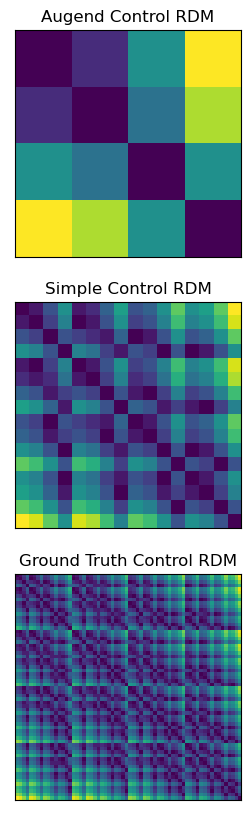

In [283]:
fig, axs = plt.subplots(3,1, figsize=(6,10))
axs = axs.flatten()
controls_rdms = [aug_RDM, simple_RDM, truth_RDM]
control_names = ['Augend', 'Simple', 'Ground Truth']
for i, r in enumerate(controls_rdms):
    ax = axs[i]
    ax.imshow(r)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.title.set_text(control_names[i]+' Control RDM')


In [ ]:
fig, ax = plt.subplots()
ax.imshow(np.array(dms_b[2]).mean(axis=0))
f = ax.set_xticks(np.arange(16))
f = ax.set_xticklabels(seqlabs, rotation=60)
f = ax.set_yticks(np.arange(16))
f = ax.set_yticklabels(seqlabs, rotation=0)
plt.suptitle('Primitive regime', y=0.93)


In [43]:
coefs3b, names3b = get_step_coeffs(allrdms5['rdms_b'],3, testseqs2, cuedicts, control_mod = 'simple')
coefs3p, names3p = get_step_coeffs(allrdms5['rdms_p'],3, testseqs2, cuedicts, control_mod = 'simple')

coefs = np.append(coefs3b, coefs3p)
curricula = ['Balanced']*len(coefs3b) + ['Primitives']*len(coefs3p)
controls = names3b + names3p
r2_df3 = pd.DataFrame({'R2': coefs, 'Control': controls, 'Curricula': curricula})

<AxesSubplot: xlabel='Control', ylabel='R2'>

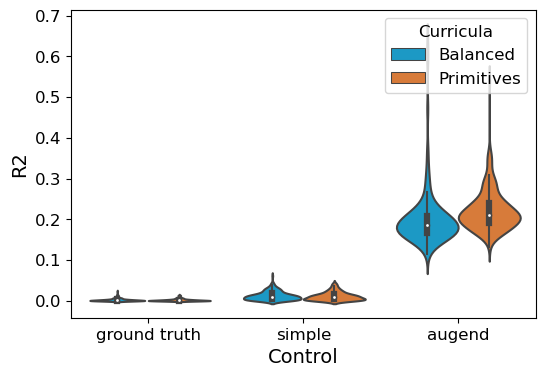

In [412]:
fig, ax = plt.subplots(figsize = (6,4))

sns.violinplot(data = r2_df3, x='Control', y='R2', hue='Curricula', palette = bp_pal)


In [378]:
fig, ax = plt.subplots(figsize = (6,4))

sns.violinplot(data = r2_df3, x='Control', y='R2', hue='Curricula', palette = bp_pal)
sns.stripplot(data = r2_df3, x='Control', y='R2', hue='Curricula', dodge = True, palette = bp_pal, size=5, jitter=0.3)
plt.setp(ax.collections, alpha=.5)

statannot.add_stat_annotation(

fig, ax = plt.subplots(figsize = (6,4))
sns.violinplot(data = r2_df3, x='Control', y='R2', hue='Curricula', palette = bp_pal)
sns.stripplot(data = r2_df3, x='Control', y='R2', hue='Curricula', dodge = True, palette = bp_pal, size=5, jitter=0.3)
plt.setp(ax.collections, alpha=.5)

statannot.add_stat_annotation(
    ax,
    data=r2_df3,
    x= 'Control',
    y='R2',
    hue = 'Curricula',
    box_pairs=[(('ground truth','Balanced'), ('ground truth','Primitives')),
               (('simple','Balanced'), ('simple','Primitives')),
              (('augend','Balanced'), ('augend','Primitives'))],
    test="Wilcoxon",
    text_format="star",
    loc="inside",
)


SyntaxError: invalid syntax (533412335.py, line 10)

In [ ]:
outs_truth = change_dict(all_seqs, cuedict)
outs_truth = [tuple_output(t[0], cue_dict) + tuple_output(t[1], cue_dict) + tuple_output(t[2], cue_dict) for t in outs_truth]
truth_RDM = abs(np.array([outs_truth]*64) - np.array([outs_truth]*64).T)

outs_aug = change_dict(all_seqs, cuedict)
outs_aug = [tuple_output(t[0], cuedict) for t in outs_aug]
aug_RDM = abs(np.array([outs_aug]*64) - np.array([outs_aug]*64).T)

outs_simple = change_dict(all_seqs, cuedict)
outs_simple = [tuple_output(t[0], cue_dict) + tuple_output(t[1], cue_dict) for t in outs_simple]
simple_RDM = abs(np.array([outs_simple]*64) - np.array([outs_simple]*64).T)


In [414]:
outs_truth = change_dict(testseqs2, cue_dict)
outs_truth = [tuple_output(t[0], cue_dict) + tuple_output(t[1], cue_dict) + tuple_output(t[2], cue_dict) for t in outs_truth]
g = abs(np.array([outs_truth]*64) - np.array([outs_truth]*64).T)


In [421]:
testseqs2[20]

[('+', 'B'), ('+', 'B'), ('+', 'A'), '=', 20]

In [420]:
outs_truth[20]

20

In [422]:
outs_truth = change_dict(testseqs2, cue_dict)
outs_truth = [t[-1] for t in outs_truth]
h = abs(np.array([outs_truth]*64) - np.array([outs_truth]*64).T)


In [142]:
outs_truth = [t[-1] for t in outs_truth]
truth_RDM = abs(np.array([outs_truth]*16) - np.array([outs_truth]*16).T)


In [ ]:
outs_1step = change_dict(all_seqs, cuedict)
outs_1step = [tuple_output(t[0], cue_dict) + tuple_output(t[1], cue_dict) for t in outs_1step]
add1step_RDM = abs(np.array([outs_1step]*16) - np.array([outs_1step]*16).T)


In [209]:
outs_step1 = [tuple_output(t[0], cue_dict) for t in testseqs2]
outs_step2 = [tuple_output(t[1], cue_dict) for t in testseqs2]
outs_step111 = [tuple_output(t[0], cue_dict) + tuple_output(t[1], cue_dict) for t in testseqs2]

In [202]:
outs_step1[1]

14

In [204]:
cue_dict

{'A': 14, 'B': 3, 'C': 11, 'D': 12}

In [214]:
j = random.randint(0, len(testseqs2))
print(testseqs2[j])
print(outs_step1[j])
print(outs_step2[j])
print(outs_step111[j])

[('+', 'D'), ('+', 'D'), ('+', 'D'), '=', 36]
12
12
24


In [14]:
ca, cb, cc, cd = 'green', 'blue', 'orange', 'red'
colors1 = [ca]*4 + [cb]*4 + [cc]*4 + [ cd]*4 + ['black']*4
colors2 = [ca, cb, cc, cd]*4 + [ca, cb, cc, cd]

msize = 12
legend_elements = [Line2D([0], [0], marker=6, color='w', markerfacecolor =ca, markersize=msize, label=' + A _'),
                   Line2D([0], [0], marker=6, color='w', markerfacecolor =cb, markersize=msize, label=' + B _'), 
                   Line2D([0], [0], marker=6, color='w', markerfacecolor =cc, markersize=msize, label=' + C _'),
                   Line2D([0], [0], marker=6, color='w', markerfacecolor =cd, markersize=msize, label=' + D _'),
                   Line2D([0], [0], marker=7, color='w', markerfacecolor=ca, markersize=msize, label=' _ + A'),
                   Line2D([0], [0], marker=7, color='w', markerfacecolor=cb, markersize=msize, label=' _ + B'), 
                   Line2D([0], [0], marker=7, color='w', markerfacecolor=cc, markersize=msize, label=' _ + C'),
                   Line2D([0], [0], marker=7, color='w', markerfacecolor=cd, markersize=msize, label=' _ + D'),
                   Line2D([0], [0], marker='_', color='black', markersize=10, label='primitive')
                   ]


In [34]:
colors1 = ([ca]*16 + [cb]*16 + [cc]*16 + [ cd]*16)*2
colors2 = ([ca]*4 + [cb]*4 + [cc]*4 + [ cd]*4)*8
colors3 = [ca, cb, cc, cd]*32

In [35]:
len(colors2)

128

In [36]:
128/4

32.0

In [139]:
def test_loss(model, testdata, criterion, hidden_size=20):
    model.eval()
    losses_testset = []
    
    for testset in testdata:
        loss_set = 0
        
        for x,y in testset:
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                loss_set += criterion(y_hat,y[i]).item()
     
        losses_testset.append(loss_set)
        
    return losses_testset

In [107]:
criterion = nn.MSELoss()

In [140]:
i = random.randint(0,200)

model = res1['mods_b'][i]
cuedict = res1['cue_dicts'][i]
 
testseqs = change_dict(testseqs, cuedict)
test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
testdata = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)


test_loss(model, [testdata, testdata], criterion)

[1021569.3879394531, 1021569.3879394531]

In [100]:
res1.keys()

dict_keys(['mods', 'mods_b', 'mods_p', 'mods_bp', 'res', 'tests', 'cue_dicts', 'acc_df'])

In [138]:
for i, j in enumerate([3,6,7,8]):
    print(i)

0
1
2
3
